In [1]:
from pathlib import Path
import torch
import numpy as np
import os

from torch import cuda
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("..")
from utils import io
from models import SegmentationModel

/home/students/s265780/.conda-envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#reports/unet_2/unet_2/epoch=85-val_rmse=7.71.ckpt  first ok
#reports/unet_2/unet_2/epoch=86-val_rmse=8.59.ckpt add torch.where()
#reports/unet_2/unet_2/epoch=72-val_rmse=7.35.ckpt add mask mult
#reports/unet/unet/epoch=97-val_rmse=7.87.ckpt unetL1
#reports/unet/unet/epoch=85-val_rmse=7.90.ckpt unet
#reports/unet/unet/epoch=85-val_rmse=7.87.ckpt unet 6.28 rmse
#reports/unet/unet/epoch=85-val_rmse=7.15.ckpt unet 5.95 rmse

model = SegmentationModel.load_from_checkpoint(Path("reports/unet/unet/epoch=0-val_rmse=24.06.ckpt"))
model.eval();

In [3]:
input_path = Path("/home/students/s265780/data/24h_10mmMAX_OI")
test_date_9 = [
    "20190807", "20181030", "20200329", "20200501", "20190505", "20200128", "20180825",
    "20210807", "20210724", "20201006", "20210628", "20220518", "20190702", "20190802",
    "20210617", "20190806", "20200519", "20190618", "20180817", "20180801", "20190703",
    "20190714", "20220331", "20190906", "20181123", "20180720", "20200617", "20220524",
    "20190919", "20210730", "20190424", "20191218", "20200609", "20180607", "20181124",
    "20200801", "20210727", "20200420", "20211031", "20190828", "20190819", "20190412",
    "20200627", "20210101", "20181029", "20200701", "20200616", "20200426", "20180714",
    "20220528", "20200921", "20190908", "20200830", "20180813", "20191022", "20210831",
    "20180830", "20210712", "20191014", "20180820", "20190710", "20210129", "20211004"
]

indices_one, indices_zero, mask = io.get_mask_indices(input_path, True) #why False?
case_study_max=483.717752
available_models = ["bol00", "e1000", "c2200", "c5m00"]
x, y, in_features, out_features = io.load_data('unet', input_path, test_date_9, case_study_max, indices_one, indices_zero, available_models)
#x[:, 0:1]=np.zeros((96,128))

In [4]:
logit_seg, logit_class = model(torch.from_numpy(x).to('cuda'), None)

#logit_seg_numpy = logit_seg.squeeze().to('cpu').detach().numpy()
logit_class = logit_class.squeeze().to('cpu').detach().numpy()

##seg = torch.round(torch.sigmoid(logit_seg)).squeeze().to('cpu').detach().numpy()
#seg = logit_seg.sigmoid().gt(.5).squeeze().to('cpu').detach().numpy()

y_seg = torch.heaviside(torch.from_numpy(y).to('cuda'), torch.tensor([0]).float().to('cuda')).squeeze().to('cpu').detach().numpy()
y_seg_num = np.squeeze(np.where(y>0.001, 1, 0))

In [5]:
#plt.imshow(seg, cmap='gray') #modello

In [6]:
#plt.imshow(y_seg_num, cmap='gray') #ground thruth

In [7]:
#plt.imshow(y_seg_num-seg, cmap='gray') #parti bianche mancano nel modello

Text(0.5, 1.0, 'model_pred')

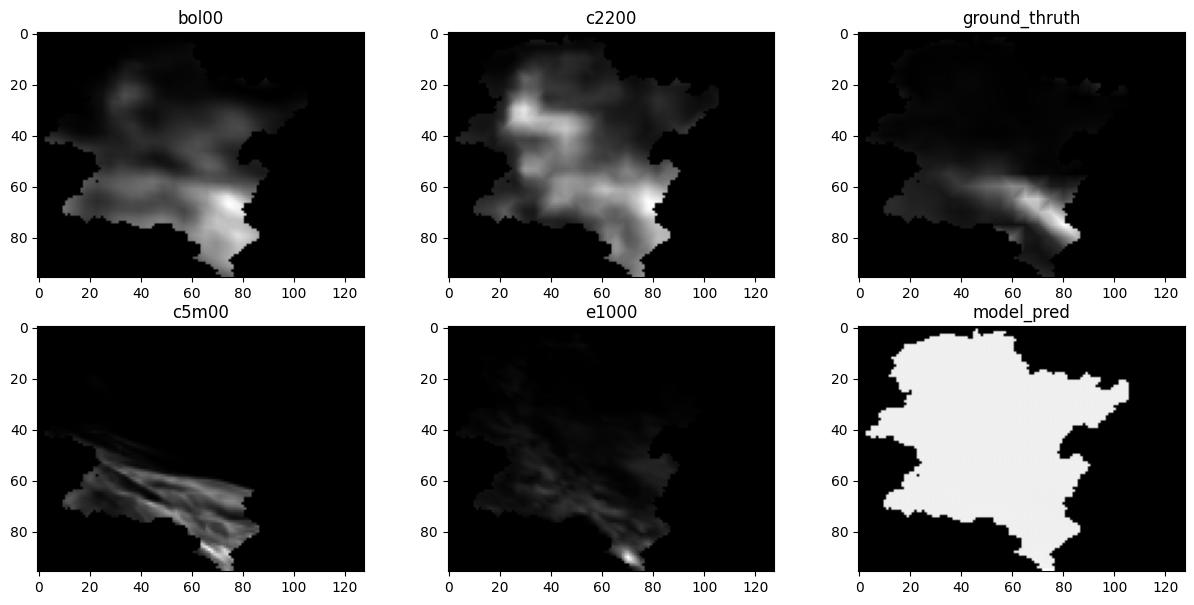

In [8]:
fig, axs = plt.subplots(2, 3 ,figsize=(15,7))
axs[0, 0].imshow(x[0][0], cmap='gray', norm='linear')
axs[0, 0].set_title('bol00')
axs[0, 1].imshow(x[0][1], cmap='gray', norm='linear')
axs[0, 1].set_title('c2200')
axs[1, 0].imshow(x[0][2], cmap='gray', norm='linear')
axs[1, 0].set_title('c5m00')
axs[1, 1].imshow(x[0][3], cmap='gray', norm='linear')
axs[1, 1].set_title('e1000')
axs[0, 2].imshow(y[0], cmap='gray', norm='linear')
axs[0, 2].set_title('ground_thruth')
axs[1, 2].imshow(logit_class[0], cmap='gray', norm='linear')
axs[1, 2].set_title('model_pred')

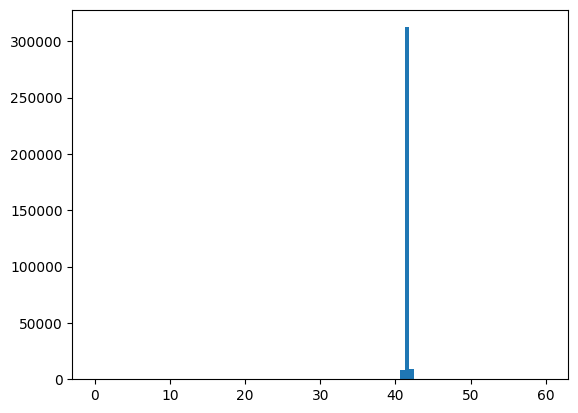

In [9]:
histo = (logit_class*case_study_max*mask).flatten()

plt.hist(histo[histo>0.1], bins=np.linspace(0,60, 100))
plt.show()

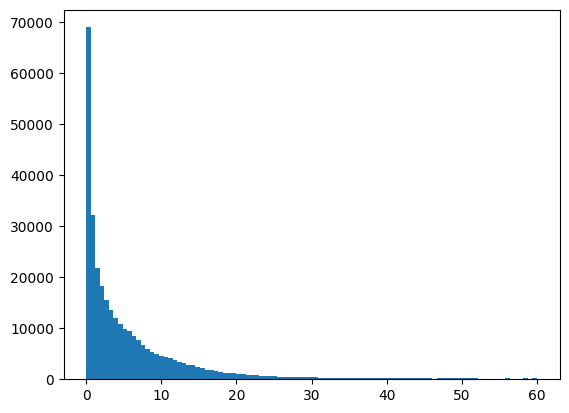

In [10]:
histo = (y*case_study_max*mask).flatten()

plt.hist(histo[histo>0.1], bins=np.linspace(0,60, 100))
plt.show()

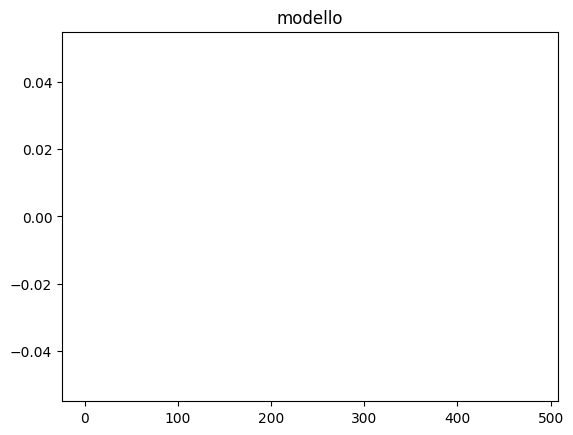

In [11]:
y_r = np.reshape(y*mask, (63, 128*96))
logit_class_r = np.reshape(logit_class*mask, (63, 128*96))
MSE = np.sqrt(np.square(logit_class_r*case_study_max-y_r*case_study_max)).sum(0)
plt.hist(MSE[MSE>0], bins=np.linspace(0,case_study_max, 200))
plt.title("modello")
plt.show()

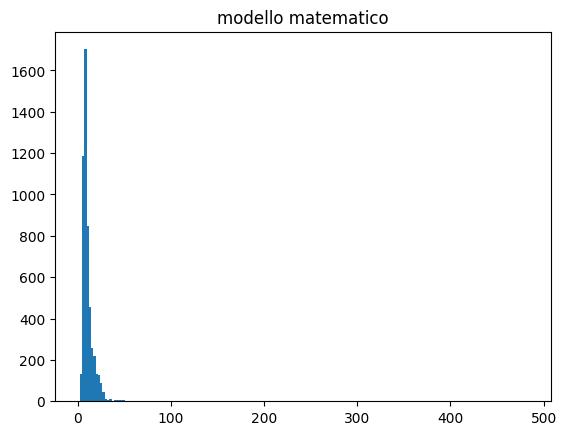

(56749.22372052174, (12288,))

In [12]:
x1_r = np.reshape(x[:, 0], (63, 128*96))
MSE = np.sqrt(np.square(y_r*case_study_max-x1_r*case_study_max).sum(0)/(63))
plt.hist(MSE[MSE>0.001], bins=np.linspace(0,case_study_max, 200))
plt.title("modello matematico")
plt.show()
MSE.sum(), np.shape(MSE)

In [13]:
np.sqrt(np.square(y_r*case_study_max-logit_class_r*case_study_max).sum()/(63*128*96))

24.196893796681945

In [14]:
np.shape(y_r)

(63, 12288)

In [15]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(y_r*case_study_max, logit_class_r*case_study_max)

15.780854014088327

In [16]:
np.shape(x1_r)

(63, 12288)

In [17]:
import torch.nn as nn

In [19]:
(nn.MSELoss()(torch.tensor(logit_class).cpu(), torch.tensor(y).cpu())*case_study_max**2)**.5

tensor(24.1969)

In [20]:
logit_class.shape

(63, 96, 128)

In [21]:
logit_class.sum()

28347.814

In [23]:
y.sum()

5164.935